In [1]:
from SimPEG import *
from simpegEM1D.simulation import EM1DTMSimulation
from simpegEM1D.survey import EM1DSurveyTD
from simpegEM1D.sources import *
from simpegEM1D.receivers import *
from simpegEM1D import analytics, Utils1D
from simpegEM1D.EM1DSimulation import *

from simpegEM1D import skytem_HM_2015
import numpy as np
%pylab inline



Populating the interactive namespace from numpy and matplotlib


In [2]:
times = np.logspace(-5, -2, 31)
rx_location = np.array([0., 0., 100.+30.])
src_location = np.array([0., 0., 100.+30.])

I = 1.
a = 13.

wave_type = "stepoff"

# Receiver list
receiver_list = [
    TimeDomainPointReceiver(
        rx_location, times, orientation="z", component="dbdt"
    )
]

source_list = [
    TimeDomainHorizontalLoopSource(
        receiver_list=receiver_list, location=src_location, a=a, I=I,
        base_frequency = 25., use_lowpass_filter=False, high_cut_frequency=210*1e3
    )
]


TDsurvey = EM1DSurveyTD(source_list)

In [3]:
sig_half = 1e-1
sig_blk = sig_half * 20.
chi_half = 0.

hz = get_vertical_discretization_time(times, facter_tmax=0.5, factor_tmin=10., n_layer=19)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 100.]

sig  = np.ones(nlay)*sig_half
blk_ind = (-30>LocSigZ) & (-70<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

expmap = maps.ExpMap(mesh1D)

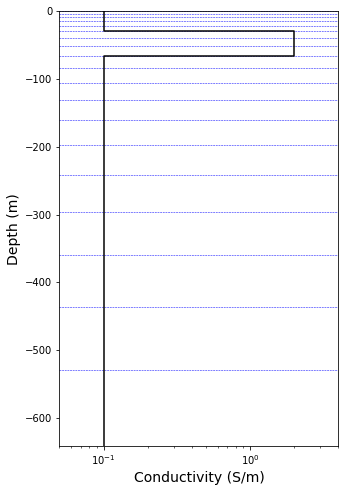

In [4]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)

In [5]:
%%time
sim = EM1DTMSimulation(
    mesh1D, survey=TDsurvey, sigmaMap=expmap, verbose=False
)
sim.chi = np.zeros(nlay)
d_true = sim.dpred(m_true)
print(d_true)

[-4.33201110e-02 -3.74342148e-02 -3.21944429e-02 -2.74832496e-02
 -2.31673558e-02 -1.91405535e-02 -1.53723456e-02 -1.19200707e-02
 -8.89247606e-03 -6.39192125e-03 -4.46682573e-03 -3.09079433e-03
 -2.17200300e-03 -1.58589851e-03 -1.21341381e-03 -9.65658351e-04
 -7.88243222e-04 -6.52425842e-04 -5.44257515e-04 -4.57288388e-04
 -3.88241761e-04 -3.34143659e-04 -2.91049718e-04 -2.54543505e-04
 -2.21031500e-04 -1.88585636e-04 -1.56868139e-04 -1.26515469e-04
 -9.85265155e-05 -7.38469377e-05 -5.31411525e-05]
Wall time: 51.1 ms


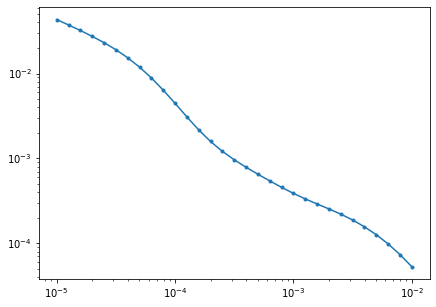

In [6]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(times, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [7]:
np.random.seed(1)
std = 0.05
noise = std*abs(d_true)*np.random.randn(len(d_true))
d_obs = d_true + noise
floor = 0.
std = 0.07
uncert = abs(d_obs)*std+floor
dataObj = data.Data(TDsurvey, dobs=d_obs, noise_floor=uncert)

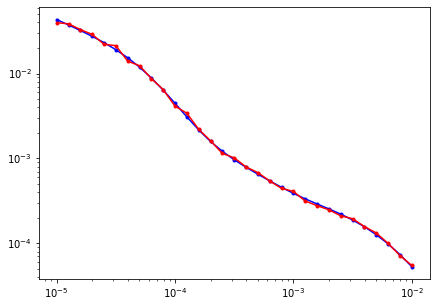

In [9]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(times, -d_true, 'b.-')
axes.plot(times, -d_obs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [10]:
dmisfit = data_misfit.L2DataMisfit(dataObj, sim)
dmisfit.W = utils.sdiag(1/uncert)

In [11]:
m0 = np.log(np.ones_like(sig)*sig_half)
d_0 = sim.dpred(m0)
# delta = prob.get_threshold(uncert)

In [12]:
reg = regularization.Sparse(
    mesh1D,
    mapping=maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
p = 0
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = directives.Update_IRLS(
    max_irls_iterations=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2,
    chifact_start = 1.
)
opt = optimization.ProjectedGNCG(maxIter = 25)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = directives.TargetMisfit()
# update_sense = Directives.UpdateSensitivityWeights(threshold=delta)
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
# prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [13]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.37e-01  1.92e+03  0.00e+00  1.92e+03    8.80e+02      0              
   1  2.18e-01  2.63e+02  2.04e+02  3.07e+02    2.10e+02      0              
   2  1.09e-01  1.33e+02  2.90e+02  1.65e+02    1.62e+02      0              
   3  5.46e-02  1.03e+02  1.31e+02  1.10e+02    1.59e+02      0              
   4  2.73e-02  3.35e+01  2.74e+02  4.10e+01    1.11e+02      0              
   5  1.36e-02  1.82e+01  2.11e+02  2.11e+01    5.09e+01      0              
------------------------- STOP! -------------------------


In [14]:
# opt.counter.summary()
# xc = opt.recall('xc')

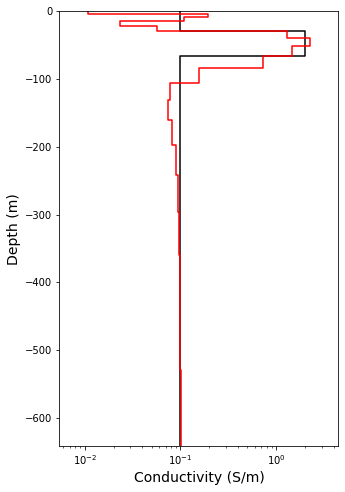

In [15]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D)
Utils1D.plotLayer(expmap*mopt, mesh1D, showlayers=False, **{'color':'r'})
# Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})

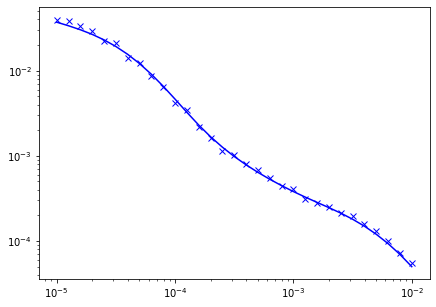

In [16]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(times, -invProb.dpred, 'b-')
axes.plot(times, -d_obs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');